# RNN / LSTM / GRU to predict Hedge Funds flows in Commodities Markets using TensorFlow / Keras

In [1]:
import quandl as ql
import numpy as np
np.random.seed(12345)

import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
tf.set_random_seed(12345)
import keras
from keras.models import Sequential
from keras.layers import Dense, SimpleRNN, LSTM, GRU
import matplotlib.pyplot as plt
import watermark

import warnings
warnings.filterwarnings('ignore')

%load_ext watermark
%matplotlib inline

Using TensorFlow backend.


In [2]:
ql.ApiConfig.api_key = 'INSERT_YOUT_TOKEN_HERE'

In [3]:
print(' Reproducibility conditions for this notebook '.center(85,'-'))
%watermark -n -v -m -p numpy,scipy,tensorflow,keras,matplotlib,sklearn,pandas
print('-'*85)

-------------------- Reproducibility conditions for this notebook -------------------
Sun Dec 01 2019 

CPython 3.7.3
IPython 7.6.1

numpy 1.16.4
scipy 1.2.1
tensorflow 1.14.0
keras 2.2.4
matplotlib 3.1.0
sklearn 0.21.2
pandas 0.24.2

compiler   : MSC v.1915 64 bit (AMD64)
system     : Windows
release    : 10
machine    : AMD64
processor  : Intel64 Family 6 Model 94 Stepping 3, GenuineIntel
CPU cores  : 8
interpreter: 64bit
-------------------------------------------------------------------------------------


## Extracting the original time series

In [4]:
cot_corn = pd.DataFrame(ql.get('CFTC/002602_F_ALL', start_date='2009-01-01'))
cot_wheat = pd.DataFrame(ql.get('CFTC/001602_F_ALL', start_date='2009-01-01'))
MM_net_CORN = pd.DataFrame(cot_corn['Money Manager Longs']-cot_corn['Money Manager Shorts'],
                          columns=['MM_Net_Position'])

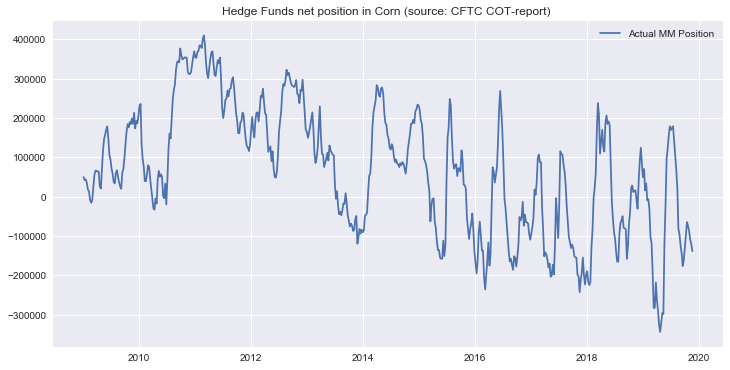

In [5]:
plt.style.use('seaborn')
plt.plot(MM_net_CORN.index, MM_net_CORN.values, label='Actual MM Position')
plt.title('Hedge Funds net position in Corn (source: CFTC COT-report) ')
plt.legend()
plt.gcf().set_size_inches(12,6)

## Feature Engineering on the original data

In [35]:
scaler = MinMaxScaler(feature_range=(-1, 1))
input_data = scaler.fit_transform(MM_net_CORN)

In [36]:
n_points = input_data.shape[0]
train_points = int(2/3*n_points)+1

train, test = input_data[:train_points], input_data[train_points:]

In [37]:
X_train, X_test = train[:-1], test[:-1]
y_train, y_test = train[1:], test[1:]

print("Sample sets split (training/testing):", 
      len(X_train), "training points and", 
      X_test.shape[0], "testing points")

Sample sets split (training/testing): 378 training points and 188 testing points


In [38]:
tf.reset_default_graph()
keras.backend.clear_session()

X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

print(X_train.shape)
print(X_test.shape)

(378, 1, 1)
(188, 1, 1)


## 1. Recurrent Neural Network (RNN) 
We'll be using a SimpleRNN model with 4 hidden units. The Dense layer at the end has a linear activation function to aggregate the outputs of all the hidden units.

In [39]:
RNN_model = Sequential()
RNN_model.add(SimpleRNN(units=8, input_shape=(X_train.shape[1], X_train.shape[2])))
RNN_model.add(Dense(1))

RNN_model.compile(loss='mean_squared_error', optimizer='adam')

RNN_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_1 (SimpleRNN)     (None, 8)                 80        
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 9         
Total params: 89
Trainable params: 89
Non-trainable params: 0
_________________________________________________________________


In [40]:
nb_epoch = 20
batch_size = 1

history = RNN_model.fit(X_train, y_train, epochs=nb_epoch, verbose=1, batch_size=batch_size, shuffle=False)

Epoch 1/20
378/378 [==============================] - 1s 3ms/step - loss: 0.0106
Epoch 2/20
378/378 [==============================] - 1s 1ms/step - loss: 0.0074
Epoch 3/20
378/378 [==============================] - 1s 1ms/step - loss: 0.0074
Epoch 4/20
378/378 [==============================] - 1s 1ms/step - loss: 0.0074
Epoch 5/20
378/378 [==============================] - 1s 1ms/step - loss: 0.0074
Epoch 6/20
378/378 [==============================] - 1s 1ms/step - loss: 0.0074
Epoch 7/20
378/378 [==============================] - 1s 1ms/step - loss: 0.0074
Epoch 8/20
378/378 [==============================] - 0s 1ms/step - loss: 0.0074
Epoch 9/20
378/378 [==============================] - 1s 2ms/step - loss: 0.0074
Epoch 10/20
378/378 [==============================] - 1s 2ms/step - loss: 0.0074
Epoch 11/20
378/378 [==============================] - 1s 2ms/step - loss: 0.0074
Epoch 12/20
378/378 [==============================] - 1s 1ms/step - loss: 0.0074
Epoch 13/20
378/378 [====

In [41]:
RNN_y_train_pred = RNN_model.predict(X_train)
RNN_y_test_pred = RNN_model.predict(X_test)
RNN_y_train_pred = scaler.inverse_transform(RNN_y_train_pred)
RNN_y_test_pred = scaler.inverse_transform(RNN_y_test_pred)

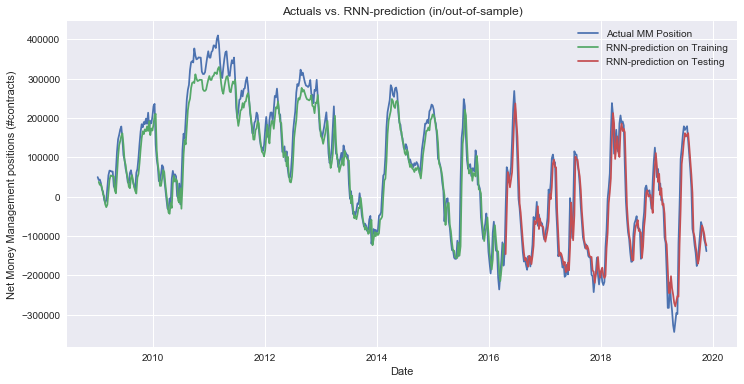

In [42]:
plt.style.use('seaborn')
plt.plot(MM_net_CORN.index, MM_net_CORN.values, label='Actual MM Position')
plt.plot(MM_net_CORN.index[1:len(RNN_y_train_pred)+1], RNN_y_train_pred, label='RNN-prediction on Training')
plt.plot(MM_net_CORN.index[len(RNN_y_train_pred)+2:], RNN_y_test_pred, label='RNN-prediction on Testing')
plt.title('Actuals vs. RNN-prediction (in/out-of-sample)')
plt.xlabel('Date')
plt.ylabel('Net Money Management positions (#contracts)')
plt.legend()
plt.gcf().set_size_inches(12,6)

In [43]:
print('\n# Evaluate on test data')
RNN_results = RNN_model.evaluate(X_test, y_test, batch_size=100)
print('test loss, test acc:', RNN_results)


# Evaluate on test data
188/188 [==============================] - 0s 568us/step
test loss, test acc: 0.015696041325622415


## 2. Long-Short Term Memmory (LSTM)

In [44]:
tf.reset_default_graph()
keras.backend.clear_session()

LSTM_model = Sequential()
LSTM_model.add(LSTM(units=8, input_shape=(X_train.shape[1], X_train.shape[2])))
LSTM_model.add(Dense(1))

LSTM_model.compile(loss='mean_squared_error', optimizer='adam')

LSTM_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 8)                 320       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 9         
Total params: 329
Trainable params: 329
Non-trainable params: 0
_________________________________________________________________


In [45]:
nb_epoch = 50
batch_size = 1

history = LSTM_model.fit(X_train, y_train, 
                        epochs=nb_epoch, 
                        verbose=1, 
                        batch_size=batch_size, 
                        shuffle=False)

Epoch 1/50
378/378 [==============================] - 2s 6ms/step - loss: 0.0950
Epoch 2/50
378/378 [==============================] - 1s 3ms/step - loss: 0.0332
Epoch 3/50
378/378 [==============================] - 1s 3ms/step - loss: 0.0098
Epoch 4/50
378/378 [==============================] - 1s 3ms/step - loss: 0.0071
Epoch 5/50
378/378 [==============================] - 1s 3ms/step - loss: 0.0069
Epoch 6/50
378/378 [==============================] - 1s 3ms/step - loss: 0.0069
Epoch 7/50
378/378 [==============================] - 1s 3ms/step - loss: 0.0068
Epoch 8/50
378/378 [==============================] - 1s 3ms/step - loss: 0.0068
Epoch 9/50
378/378 [==============================] - 1s 3ms/step - loss: 0.0068
Epoch 10/50
378/378 [==============================] - 1s 3ms/step - loss: 0.0069
Epoch 11/50
378/378 [==============================] - 1s 3ms/step - loss: 0.0069
Epoch 12/50
378/378 [==============================] - 1s 3ms/step - loss: 0.0069
Epoch 13/50
378/378 [====

In [46]:
LSTM_y_train_pred = LSTM_model.predict(X_train)
LSTM_y_test_pred = LSTM_model.predict(X_test)

LSTM_y_train_pred = scaler.inverse_transform(LSTM_y_train_pred)
LSTM_y_test_pred = scaler.inverse_transform(LSTM_y_test_pred)


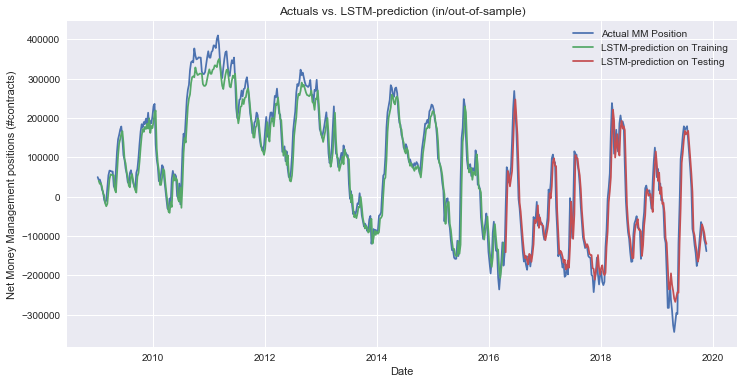

In [47]:
plt.style.use('seaborn')
plt.plot(MM_net_CORN.index, MM_net_CORN.values, label='Actual MM Position')
plt.plot(MM_net_CORN.index[1:len(LSTM_y_train_pred)+1], LSTM_y_train_pred, label='LSTM-prediction on Training')
plt.plot(MM_net_CORN.index[len(LSTM_y_train_pred)+2:], LSTM_y_test_pred, label='LSTM-prediction on Testing')
plt.title('Actuals vs. LSTM-prediction (in/out-of-sample)')
plt.xlabel('Date')
plt.ylabel('Net Money Management positions (#contracts)')
plt.legend()
plt.gcf().set_size_inches(12,6)

In [48]:
print('\n# Evaluate on test data')
LSTM_results = LSTM_model.evaluate(X_test, y_test, batch_size=100)
print('test loss, test acc:', LSTM_results)


# Evaluate on test data
188/188 [==============================] - 0s 991us/step
test loss, test acc: 0.015811222387438126


# 3. Gated Recurrent Units (GRU)

In [22]:
tf.reset_default_graph()
keras.backend.clear_session()

GRU_model = Sequential()
GRU_model.add(GRU(units=8, batch_input_shape=(1, X_train.shape[1], X_train.shape[2])))
GRU_model.add(Dense(1))
GRU_model.compile(loss='mean_squared_error', optimizer='adam')
GRU_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_1 (GRU)                  (1, 8)                    240       
_________________________________________________________________
dense_1 (Dense)              (1, 1)                    9         
Total params: 249
Trainable params: 249
Non-trainable params: 0
_________________________________________________________________


In [23]:
nb_epoch = 25
batch_size = 1

history = GRU_model.fit(X_train, y_train, 
                        epochs=nb_epoch, 
                        verbose=1, 
                        batch_size=batch_size, 
                        shuffle=False)

Epoch 1/25
378/378 [==============================] - 2s 4ms/step - loss: 0.0440
Epoch 2/25
378/378 [==============================] - 1s 2ms/step - loss: 0.0109
Epoch 3/25
378/378 [==============================] - 1s 2ms/step - loss: 0.0070
Epoch 4/25
378/378 [==============================] - 1s 2ms/step - loss: 0.0068
Epoch 5/25
378/378 [==============================] - 1s 2ms/step - loss: 0.0068
Epoch 6/25
378/378 [==============================] - 1s 2ms/step - loss: 0.0069
Epoch 7/25
378/378 [==============================] - 1s 2ms/step - loss: 0.0069
Epoch 8/25
378/378 [==============================] - 1s 2ms/step - loss: 0.0069
Epoch 9/25
378/378 [==============================] - 1s 2ms/step - loss: 0.0069
Epoch 10/25
378/378 [==============================] - 1s 2ms/step - loss: 0.0069
Epoch 11/25
378/378 [==============================] - 1s 2ms/step - loss: 0.0069
Epoch 12/25
378/378 [==============================] - 1s 2ms/step - loss: 0.0069
Epoch 13/25
378/378 [====

In [24]:
GRU_y_train_pred = GRU_model.predict(X_train)
GRU_y_test_pred = GRU_model.predict(X_test)

GRU_y_train_pred = scaler.inverse_transform(GRU_y_train_pred)
GRU_y_test_pred = scaler.inverse_transform(GRU_y_test_pred)

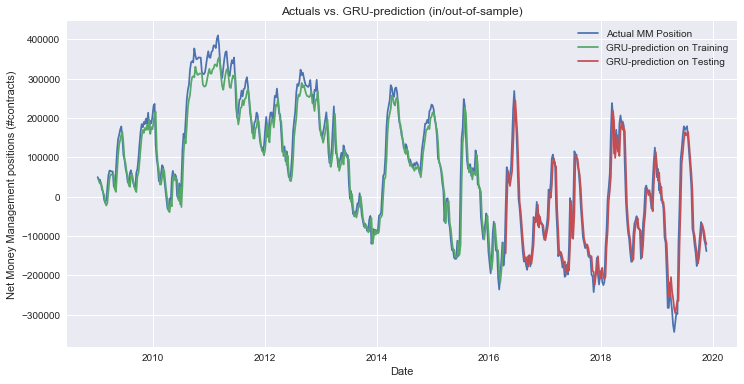

In [25]:
plt.style.use('seaborn')
plt.plot(MM_net_CORN.index, MM_net_CORN.values, label='Actual MM Position')
plt.plot(MM_net_CORN.index[1:len(GRU_y_train_pred)+1], GRU_y_train_pred, label='GRU-prediction on Training')
plt.plot(MM_net_CORN.index[len(GRU_y_train_pred)+2:], GRU_y_test_pred, label='GRU-prediction on Testing')
plt.title('Actuals vs. GRU-prediction (in/out-of-sample)')
plt.xlabel('Date')
plt.ylabel('Net Money Management positions (#contracts)')
plt.legend()
plt.gcf().set_size_inches(12,6)

In [33]:
print('\n# Evaluate on test data')
GRU_results = GRU_model.evaluate(X_test, y_test, batch_size=100)
print('test loss, test acc:', GRU_results)


# Evaluate on test data
188/188 [==============================] - 0s 21us/step
test loss, test acc: 0.015338763554996632


## 4. Summary of results

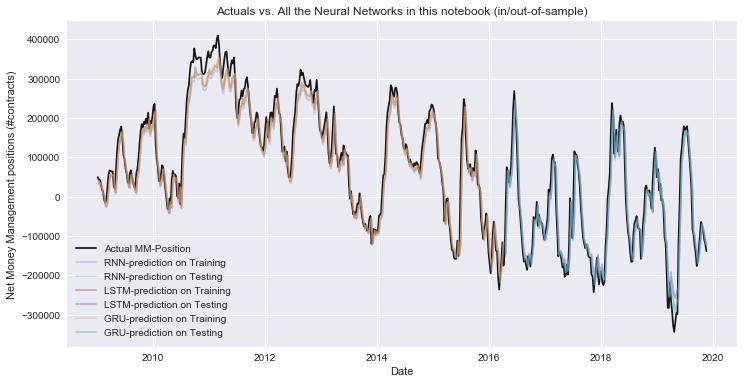

In [28]:
plt.style.use('seaborn')
#plt.style.use('bmh')
plt.plot(MM_net_CORN.index, MM_net_CORN.values, 
         label='Actual MM-Position', 
         color='k',
        alpha=.9)
plt.plot(MM_net_CORN.index[1:len(RNN_y_train_pred)+1], RNN_y_train_pred, 
         label='RNN-prediction on Training',
         alpha=.25,)
plt.plot(MM_net_CORN.index[len(RNN_y_train_pred)+2:], RNN_y_test_pred, 
         label='RNN-prediction on Testing',
         alpha=.25)
plt.plot(MM_net_CORN.index[1:len(LSTM_y_train_pred)+1], LSTM_y_train_pred, 
         label='LSTM-prediction on Training',
         alpha=.5)
plt.plot(MM_net_CORN.index[len(LSTM_y_train_pred)+2:], LSTM_y_test_pred, 
         label='LSTM-prediction on Testing',
        alpha=.5)
plt.plot(MM_net_CORN.index[1:len(GRU_y_train_pred)+1], GRU_y_train_pred, 
         label='GRU-prediction on Training',
        alpha=.5)
plt.plot(MM_net_CORN.index[len(GRU_y_train_pred)+2:], GRU_y_test_pred, 
         label='GRU-prediction on Testing',
        alpha=.5)
plt.title('Actuals vs. All the Neural Networks in this notebook (in/out-of-sample)')
plt.xlabel('Date')
plt.ylabel('Net Money Management positions (#contracts)')
plt.legend()
plt.gcf().set_size_inches(12,6)